In [3]:
import numpy as np
%matplotlib inline
import networkx as nx 
import torch 
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

from torch_geometric.nn import GATConv, GraphSAGE, GCNConv
import torch.nn.functional as F
from torch_geometric.utils import to_networkx

In [6]:
np.arange(100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [53]:
n_f = 4
n_t = 5

def getW(m_targets, n_communities, j_features, w_degree=0, w_x=3, scale=1.5, com_relevance= True):
    """
    Generate community beta matrix with row-wise exponential distributed values. if community info
    is relevant.
    :param m_targets: 
    :param n_communities: 
    :param j_features: 
    :param w_degree: 
    :param w_x: 
    :param scale: 
    :param com_relevance: 
    :return: 
    """
    degree_betas = np.random.normal(loc=w_degree, scale=.5, size=(m_targets, 1))
    x_betas = np.random.normal(loc=w_degree, scale=.5, size=(j_features, m_targets)).T
    
    if com_relevance:
        community_betas = np.power(np.random.exponential(scale, (n_communities, m_targets)).T, scale)
    else:
        community_betas = np.random.uniform(size=(m_targets,n_communities))
    
    return np.hstack((degree_betas, x_betas, community_betas))
        
    

getW(5,4)

array([[ 0.40233198,  3.75470351,  0.14153737,  0.54039138],
       [ 0.16768221,  1.55025468,  0.30097941,  4.27343986],
       [ 4.82561322, 24.9879881 ,  0.21790606,  1.04202209],
       [ 1.89402288,  0.38070892,  0.06004908,  2.12471598],
       [ 7.8022204 , 10.05793859,  2.60256192,  2.65295553]])

array([0.13508517])

### NNet training: 

- When designing a neural network for tasks like classification or regression, each input neuron corresponds to one feature
- The number of observations does not directly determine the architecture of the neural network. Each observation is *processed independently* by the network during training and inference, but it doesn't affect the structure of the network itself.
- In graph neural networks (GNNs), the representation of each node typically depends on its local neighborhood in the graph. Since each node in the graph can have a different set of neighbors, the messages passed between nodes and the resulting representations will be different for each node.

Here's a high-level overview of how a GNN processes each node in the graph:

1. Message Passing: At each layer of the GNN, each node aggregates information from its neighbors. This aggregation process involves passing messages between neighboring nodes and combining these messages to update the node's representation.
2. Neighborhood Aggregation: The way information is aggregated from the neighborhood of each node can vary depending on the specific GNN architecture. Common aggregation methods include summing, averaging, or using attention mechanisms to weight the contributions of neighboring nodes.
3. Node Representation Update: Once the messages from neighboring nodes are aggregated, they are combined with the node's own features to update the node's representation. This updated representation captures information from both the node itself and its local neighborhood.
4. Propagation: This process of message passing and representation update is typically performed iteratively for multiple layers in the GNN. Each layer refines the node representations by considering information from increasingly distant parts of the graph.

Because each node has a different set of neighbors, the messages passed and the resulting node representations will be unique to each node. This allows the GNN to capture the local graph structure and learn informative embeddings for each node in the graph.

##### There are a few drawbacks to using GNNs. Understanding them will help us determine when to use GNNa and how to optimize the performance of our machine learning models. 

- Most neural networks can go deep to obtain better performance, whereas GNNs are shallow networks mostly with three layers. It limits us from achieving state-of-the-art performance on large datasets.
- The graph structures are constantly changing, making it harder to train a model on it. 
- Deploying the model to production faces scalability issues as these networks are computationally expensive. If you have a large and complex graph structure, it will be hard for you to scale the GNNs in production. 

**Contrary to other neural Network architectures, every node has its own neural network structure**

In [4]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]  # Get the first graph object. Has only one.
print('======================')
print(data)
print('======================')
# Get the adjacency matrix from the NetworkX graph
print(nx.to_numpy_array(to_networkx(dataset[0])))

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


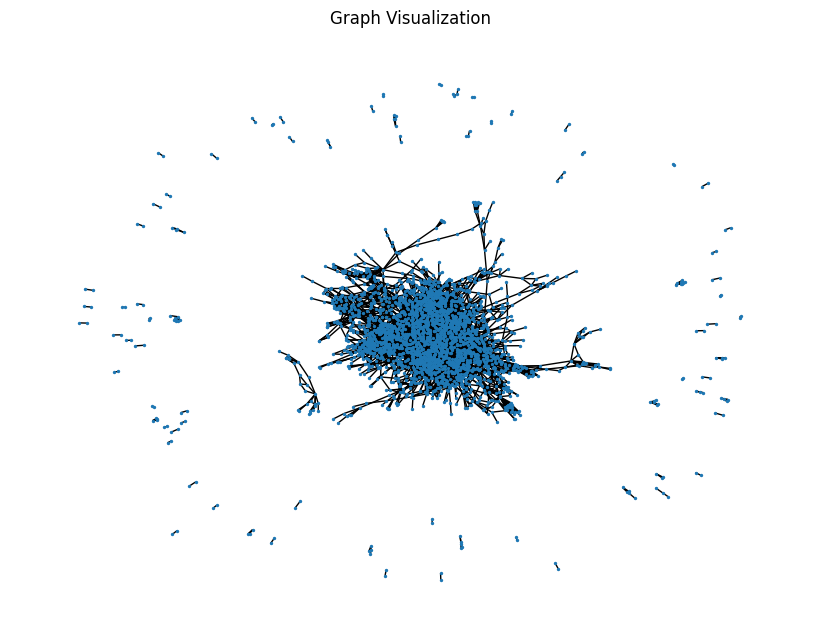

In [3]:
edge_index = dataset[0].edge_index
G = nx.Graph()

src, dst = edge_index
edges = [(src[i].item(), dst[i].item()) for i in range(edge_index.size(1))]
G.add_edges_from(edges)
 
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=False, node_size=2)
plt.title('Graph Visualization')
plt.show()

In [91]:
print(sum(data.train_mask))
print(sum(data.test_mask))
print(sum(data.val_mask))
# Does not add up to 2708 


tensor(140)
tensor(1000)
tensor(500)


tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        # Number of features as input dimension ! 
        self.conv1 = GCNConv(dataset.num_features, hidden_channels) # in-dim , out-dim
        #self.conv1_2 = GCNConv(hidden_channels, hidden_channels) 
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes) # in-dim , out-dim

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) # x represents the input node features.
        x = x.relu() # non-linear transformation of the output of the first layer 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
def visualize(h, color):
    # condense 1433 features into 2 with TSNE 
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    # explicitly remove the computational graph of the tensor using the detach() command

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
model.eval()
 # sets the model to evaluation mode. This is important because it disables dropout layers and batch normalization layers, which behave differently during training and inference.

out = model(data.x, data.edge_index)
# The output of the model is stored in the variable out. This output represents the model's predictions or representations for the given input data.
# out.shape -> torch.Size([2708, 7])

print("...")
visualize(out, color=data.y)
# model not trained yet, scatter plot looks random 

In [15]:
print(data.edge_index.dtype)
print(data.x.dtype)
print(data.y.dtype)
print(data.train_mask.dtype)

torch.int64
torch.float32
torch.int64
torch.bool


### We will train our model on 100 Epochs using Adam optimization and the Cross-Entropy Loss function (node prediction task). 


In [11]:
model = GCN(hidden_channels=16) # initialize here

# Hyperparameters for the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) 
criterion = torch.nn.CrossEntropyLoss()

def train():
      # set model to train mode (behaves different compared toeval mode:
      model.train()  
      
      # clears the gradients of all optimized parameters. Gradients are stored by default (don't cumulate?):
      optimizer.zero_grad() 

      # Perform forward pass
      out = model(data.x, data.edge_index) # = model.forward(data.x, data.edge_index) !
      # Note: out = model(data.x, data.edge_index), it's implicitly calling the forward method of the model instance. This is because PyTorch defines the __call__ method in the torch.nn.Module class, which internally calls the forward method
      #dim = number_nodes x number_features 
      
      # compares the model's predictions (out) for the training nodes (data.train_mask) against the ground truth labels (data.y[data.train_mask]):
      loss = criterion(out[data.train_mask],
                       data.y[data.train_mask]) # pred - y 
      
      # compute the gradients of the loss with respect to all model parameters:
      loss.backward()
      
      # update the model parameters based on the computed gradients and "optimizer".
      optimizer.step()
      return loss

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# By specifying the training mask only when calculating the loss, you ensure that the loss is calculated correctly only for the training nodes. The model itself does not need to be aware of the mask when computing the output; it simply produces predictions for all nodes in the graph. This approach is both correct and efficient.

False
Epoch: 001, Loss: 1.9463
False
Epoch: 002, Loss: 1.9409
False
Epoch: 003, Loss: 1.9343
False
Epoch: 004, Loss: 1.9275
False
Epoch: 005, Loss: 1.9181
False
Epoch: 006, Loss: 1.9086
False
Epoch: 007, Loss: 1.9015
False
Epoch: 008, Loss: 1.8933
False
Epoch: 009, Loss: 1.8808
False
Epoch: 010, Loss: 1.8685
False
Epoch: 011, Loss: 1.8598
False
Epoch: 012, Loss: 1.8482
False
Epoch: 013, Loss: 1.8290
False
Epoch: 014, Loss: 1.8233
False
Epoch: 015, Loss: 1.8057
False
Epoch: 016, Loss: 1.7966
False
Epoch: 017, Loss: 1.7825
False
Epoch: 018, Loss: 1.7617
False
Epoch: 019, Loss: 1.7491
False
Epoch: 020, Loss: 1.7310
False
Epoch: 021, Loss: 1.7147
False
Epoch: 022, Loss: 1.7056
False
Epoch: 023, Loss: 1.6954
False
Epoch: 024, Loss: 1.6697
False
Epoch: 025, Loss: 1.6538
False
Epoch: 026, Loss: 1.6312
False
Epoch: 027, Loss: 1.6161
False
Epoch: 028, Loss: 1.5899
False
Epoch: 029, Loss: 1.5711
False
Epoch: 030, Loss: 1.5576
False
Epoch: 031, Loss: 1.5393
False
Epoch: 032, Loss: 1.5137
False
Ep

In [54]:
def mod_evaluation():
      # Set to evaluation mode. This ensures that layers like dropout and batch normalization behave correctly during evaluation by disabling their stochastic behavior.
      model.eval()
      
      # Obtain the class lables probs: torch.Size([2708, 7])
      out = model(data.x, data.edge_index) 
      
      # This effectively selects the class with the highest probability as the predicted class for each node.
      pred = out.argmax(dim=1)
      
      # Compute accuracy 
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

test_acc = mod_evaluation()
print(f'Test Accuracy: {test_acc:.4f}')

torch.Size([2708, 7])
tensor([3, 4, 4,  ..., 0, 3, 3])
Test Accuracy: 0.8150


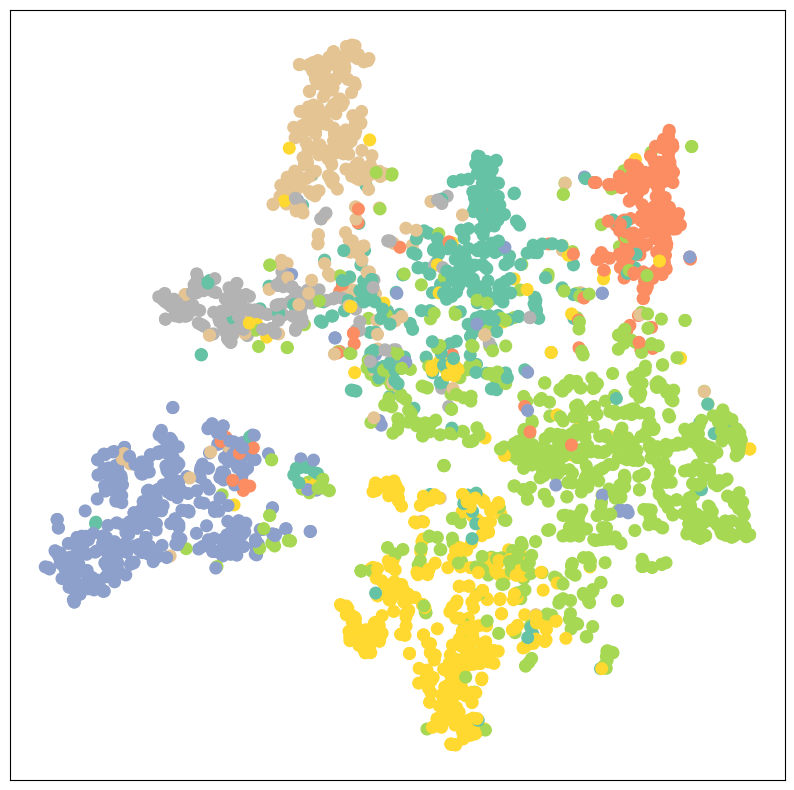

In [74]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Graph ATtenioanl network 

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.3520, Test: 0.3770
Epoch: 002, Loss: 3.9926, Val: 0.4760, Test: 0.5240
Epoch: 003, Loss: 3.9555, Val: 0.5000, Test: 0.5560
Epoch: 004, Loss: 3.9104, Val: 0.5440, Test: 0.5740
Epoch: 005, Loss: 3.8645, Val: 0.5500, Test: 0.5870
Epoch: 006, Loss: 3.8111, Val: 0.5560, Test: 0.5800
Epoch: 007, Loss: 3.7478, Val: 0.5460, Test: 0.5730
Epoch: 008, Loss: 3.6821, Val: 0.5320, Test: 0.5650
Epoch: 009, Loss: 3.6151, Val: 0.5280, Test: 0.5610
Epoch: 010, Loss: 3.5253, Val: 0.5220, Test: 0.5570
Epoch: 011, Loss: 3.4305, Val: 0.5080, Test: 0.5490
Epoch: 012, Loss: 3.3468, Val: 0.5040, Test: 0.5430
Epoch: 013, Loss: 3.2313, Val: 0.4900, Test: 0.5280
Epoch: 014, Loss: 3.1400, Val: 0.4800, Test: 0.5180
Epoch: 015, Loss: 3.0162, Val: 0.4700, Test: 0.5080
Epoch: 016, Loss: 2.9145, Val: 0.4620, Test: 0.4990
Epoch: 017, Loss: 2.7860, Val: 0.4520, Test: 0.4940
Epoch: 018, Loss: 2.6948, Val: 0.4340

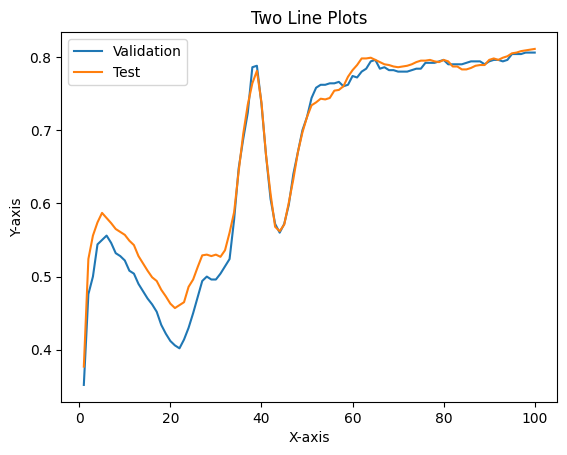

In [4]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training) # dropout typically after activation function 
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005,
                             weight_decay=5e-4) # regularization technique 
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')


plt.plot(list(range(1, 101)), val_acc_all, label='Validation')
plt.plot(list(range(1, 101)), test_acc_all, label='Test')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

In [1]:
# Python Packages
import pickle
import torch
import numpy as np
from GNN_Models import ThreeLayerGCN
import torch_geometric
from datetime import datetime

# Custom Modules
from ParametricGraphModels.ADC_SBM import ADC_SBM, getB, from_config
from config import note_config, MultiClassClassification as MCC

In [9]:
# 1) Generate the Graph with a specified Configuration
graph_params = MCC.overlap_assort_seperated
g1 = from_config(graph_params)
g2 = from_config(graph_params)
g3 = from_config(graph_params)